<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/gaussian_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report , mean_squared_error, make_scorer
import requests
from scipy import stats
from numpy import absolute
from numpy import mean
from numpy import std

import lightgbm as lgb

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GaussianNoise, Activation
from tensorflow.keras.optimizers import SGD

In [64]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [65]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [66]:
features = [f for f in train.columns if 'feature' in f]
X_train, X_test, y_train, y_test = train_test_split(train[features], target, test_size=0.25, shuffle=False)

In [72]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))

In [90]:

def evaluate_model(n_nodes,train_x, train_y, test_x, test_y):
    n_input, n_classes = train_x.shape[1], train_y.shape[1]

    model = Sequential()
    model.add(Dense(n_nodes, input_dim=n_input, activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(n_classes, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mse', optimizer=opt, metrics=['mean_squared_error'])
    history = model.fit(train_x, train_y, epochs=100, verbose=0, batch_size=4096)
    preds = model.predict(X_test)
    scorer(test_y.target_r, preds[:, 0])
    scorer(test_y.target_g, preds[:, 1])
    scorer(test_y.target_b, preds[:, 2])


    _, test_mse = model.evaluate(test_x, test_y, verbose=0, batch_size=4096)

    return history, test_mse,model

Score as calculated for the leader board (っಠ‿ಠ)っ 0.34539817332516826
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5109059564090986
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6601408757103979
nodes=32: 0.092
Score as calculated for the leader board (っಠ‿ಠ)っ 0.36102505628282355
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5178270196807437
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6577577064175488
nodes=64: 0.092
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3477057934305178
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5138090122010022
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6581103535471083
nodes=128: 0.092
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3500879288488816
Score as calculated for the leader board (っಠ‿ಠ)っ 0.515409523892172
Score as calculated for the leader board (っಠ‿ಠ)っ -0.5991926084127158
nodes=256: 0.198
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3456225615627132
Score as calculated for the leader board (っಠ‿ಠ)っ

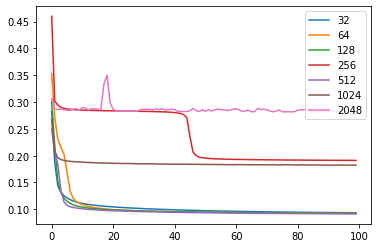

In [91]:
num_nodes = [32, 64, 128, 256, 512, 1024, 2048]
for n_nodes in num_nodes:
    history, result, model = evaluate_model(n_nodes,X_train, y_train, X_test, y_test)
    print('nodes=%d: %.3f' % (n_nodes, result))
    plt.plot(history.history['loss'], label=str(n_nodes))
plt.legend()
plt.show()

In [158]:
from sklearn.metrics import mean_squared_error
def evaluate_model(n_layers,train_x, train_y, test_x, test_y):
    n_input, n_classes = train_x.shape[1], train_y.shape[1]

    model = Sequential()
    model.add(Dense(64, input_dim=n_input, activation='relu',kernel_initializer='he_uniform'))
    for _ in range(1, n_layers):
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))

    model.add(Dense(n_classes, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_squared_error'])
    history = model.fit(train_x, train_y, epochs=25, validation_data=(test_x, test_y), verbose=1, batch_size=64)
    preds = model.predict(X_test)
    print("TARGET_R: ", mean_squared_error(test_y.target_r, preds[:, 0]))
    print("TARGET_G: ", mean_squared_error(test_y.target_g, preds[:, 1]))
    print("TARGET_B: ", mean_squared_error(test_y.target_b, preds[:, 2]))

    scorer(test_y.target_r, preds[:, 0])
    scorer(test_y.target_g, preds[:, 1])
    scorer(test_y.target_b, preds[:, 2])
    _, test_mse = model.evaluate(test_x, test_y, verbose=0, batch_size=64)
    return history, test_mse, model

In [188]:
from sklearn.metrics import mean_squared_error
def evaluate_model(gaus_noise,train_x, train_y, test_x, test_y):
    n_input, n_classes = train_x.shape[1], train_y.shape[1]

    model = Sequential()
    model.add(Dense(64, input_dim=n_input, activation='relu',kernel_initializer='he_uniform'))
    for _ in range(1, 10):
        model.add(Dense(64,kernel_initializer='he_uniform'))
        model.add(GaussianNoise(gaus_noise))
        model.add(Activation('relu'))

    model.add(Dense(n_classes, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_squared_error'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y), verbose=0, batch_size=64)
    preds = model.predict(X_test)
    print("TARGET_R: ", mean_squared_error(test_y.target_r, preds[:, 0]))
    print("TARGET_G: ", mean_squared_error(test_y.target_g, preds[:, 1]))
    print("TARGET_B: ", mean_squared_error(test_y.target_b, preds[:, 2]))

    scorer(test_y.target_r, preds[:, 0])
    scorer(test_y.target_g, preds[:, 1])
    scorer(test_y.target_b, preds[:, 2])
    _, test_mse = model.evaluate(test_x, test_y, verbose=0, batch_size=64)
    return history, test_mse, model

TARGET_R:  0.11389539643460088
TARGET_G:  0.08969730612502264
TARGET_B:  0.07060400985056982
Score as calculated for the leader board (っಠ‿ಠ)っ 0.35747810257555346
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5279347429908543
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6664886420747524
layers=0: 0.091
TARGET_R:  0.11324901747352091
TARGET_G:  0.0898309954501411
TARGET_B:  0.0706831179649443
Score as calculated for the leader board (っಠ‿ಠ)っ 0.35652573328502946
Score as calculated for the leader board (っಠ‿ಠ)っ 0.524424912411082
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6625022355603143
layers=0: 0.091
TARGET_R:  0.11289628657954555
TARGET_G:  0.08866942771868756
TARGET_B:  0.06959068588113347
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3624043107343664
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5306668104333255
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6658398222014392
layers=0: 0.090
TARGET_R:  0.11383871442105116
TARGET_G:  0.08941891622633291


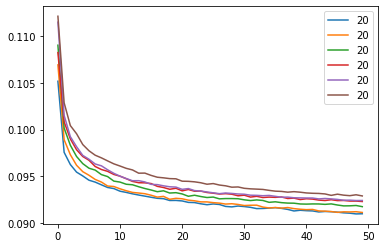

In [190]:
noise = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
for gaus_noise in noise:

    history,result, model = evaluate_model(gaus_noise, X_train, y_train , X_test, y_test)
    print('layers=%d: %.3f' % (gaus_noise, result))
    plt.plot(history.history['mean_squared_error'], label=str(n_layers))
plt.legend()
plt.show()

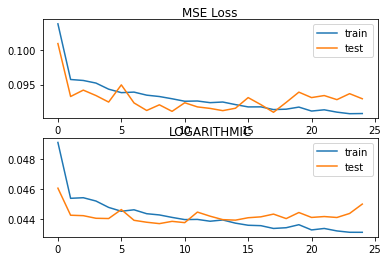

In [184]:
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['mean_squared_error'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='test')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('LOGARITHMIC', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [191]:
from sklearn.metrics import mean_squared_error
def evaluate_model(n_layers,train_x, train_y, test_x, test_y):
    n_input, n_classes = train_x.shape[1], train_y.shape[1]

    model = Sequential()
    model.add(Dense(64, input_dim=n_input, activation='relu',kernel_initializer='he_uniform'))
    for _ in range(1, n_layers):
        model.add(Dense(64,kernel_initializer='he_uniform'))
        model.add(GaussianNoise(0.35))
        model.add(Activation('relu'))

    model.add(Dense(n_classes, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_squared_error'])
    history = model.fit(train_x, train_y, epochs=50, validation_data=(test_x, test_y), verbose=0, batch_size=64)
    preds = model.predict(X_test)
    print("TARGET_R: ", mean_squared_error(test_y.target_r, preds[:, 0]))
    print("TARGET_G: ", mean_squared_error(test_y.target_g, preds[:, 1]))
    print("TARGET_B: ", mean_squared_error(test_y.target_b, preds[:, 2]))

    scorer(test_y.target_r, preds[:, 0])
    scorer(test_y.target_g, preds[:, 1])
    scorer(test_y.target_b, preds[:, 2])
    _, test_mse = model.evaluate(test_x, test_y, verbose=0, batch_size=64)
    return history, test_mse, model

TARGET_R:  0.11434029731942279
TARGET_G:  0.08984548254180572
TARGET_B:  0.07107053659386393
Score as calculated for the leader board (っಠ‿ಠ)っ 0.3573367663493907
Score as calculated for the leader board (っಠ‿ಠ)っ 0.5317825633122959
Score as calculated for the leader board (っಠ‿ಠ)っ 0.6704623899702783
layers=0: 0.092


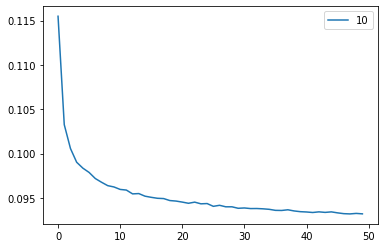

In [195]:
layers = [10]
for n_layers in layers:

    history,result, model = evaluate_model(n_layers, X_train, y_train , X_test, y_test)
    print('layers=%d: %.3f' % (gaus_noise, result))
    plt.plot(history.history['mean_squared_error'], label=str(n_layers))
plt.legend()
plt.show()

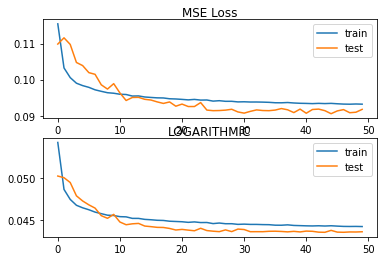

In [196]:
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['mean_squared_error'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='test')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('LOGARITHMIC', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [197]:
model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2397 (Dense)           (None, 64)                1920      
_________________________________________________________________
dense_2398 (Dense)           (None, 64)                4160      
_________________________________________________________________
gaussian_noise_195 (Gaussian (None, 64)                0         
_________________________________________________________________
activation_195 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_2399 (Dense)           (None, 64)                4160      
_________________________________________________________________
gaussian_noise_196 (Gaussian (None, 64)                0         
_________________________________________________________________
activation_196 (Activation)  (None, 64)             

In [198]:
prediction = pd.DataFrame(model.predict(test[features]), columns=['target_r', 'target_g', 'target_b'])

In [199]:
prediction

,target_r,target_g,target_b
0,0.449978,0.423645,0.355693
1,0.507157,0.516224,0.494657
2,0.362974,0.307590,0.230854
3,0.533579,0.566961,0.593300
4,0.455176,0.429934,0.360449
...,...,...,...
48532,0.592149,0.635045,0.642429
48533,0.692236,0.778208,0.850559
48534,0.638516,0.701385,0.737456
48535,0.686040,0.772011,0.856419


In [201]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
